In [64]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm
import os
import pickle

In [66]:
# Defining the seasons and models used
seasons = ['2022-23','2020-21','2019-20','2018-19','2017-18','2016-17','2015-16','2014-15','2013-14',
          '2012-13','2011-12','2010-11','2009-10','2008-09','2007-08','2006-07','2005-06','2004-05','2003-04',
           '2002-03','2001-02'] 

           
models = ['SVR','Elastic Net','Random Forest','AdaBoost','Gradient Boosting','LGBM']

#models = ['SVM']

# Path to local folder
#path_data = r'D:\Gabriel\Documentos\Modelo MVP'
path_data=r''

sep = r'/'

In [29]:
#Reding the data from the csv files and concatenating the columns

In [30]:
def get_data(seasons):
    
    # Opening the data
    per_game = pd.DataFrame()
    totals = pd.DataFrame()
    avancados = pd.DataFrame()
    standings = pd.DataFrame()

    for season in seasons:
        pergame = pd.read_csv(season+' Por Jogo.csv',
                               sep=',', decimal='.')
        
        
        total = pd.read_csv(season+' Total.csv',
                            sep=',', decimal='.')
        
        avancado = pd.read_csv(season+' Avançados.csv',
                               sep=',', decimal='.')
        
        standing = pd.read_csv(season+' Standings.csv',
                               sep=',', decimal='.')
        
        
        pergame['Season'] = season
        total['Season'] = season
        avancado['Season'] = season
        standing['Season'] = season
        
        per_game = pd.concat([per_game,pergame], ignore_index=True)
        totals = pd.concat([totals,total], ignore_index=True)
        avancados = pd.concat([avancados,avancado], ignore_index=True)
        standings = pd.concat([standings,standing], ignore_index=True)

    return per_game, totals, avancados, standings

In [31]:
#Performing Data Cleaning 

In [32]:
def treat_data(per_game, totals, avancados, standings, seasons):
    
    # Removing duplicate/empty columns
    per_game = per_game.drop(['Rk','Pos'], axis=1)
    totals = totals.drop(['Rk','Pos','Age','G','GS'], axis=1)
    avancados = avancados.drop(['Rk','Pos','Age','G','MP','Unnamed: 24','Unnamed: 19'], axis=1)
    cols = ['Player','Season','Pos','Age','Tm','G','GS']
    
    
    
    # Identifying the variables
    for coluna in per_game.columns:
        if coluna not in cols:
            nova_coluna = coluna+'_PERGAME'
            per_game = per_game.rename(columns={coluna:nova_coluna})
    for coluna in totals.columns:
        if coluna not in cols:
            nova_coluna = coluna+'_TOTAL'
            totals = totals.rename(columns={coluna:nova_coluna})
    for coluna in avancados.columns:
        if coluna not in cols:
            nova_coluna = coluna+'_AVANCADO'
            avancados = avancados.rename(columns={coluna:nova_coluna})
    
    
    # Merging the bases
    data = per_game.merge(avancados, on=['Player','Season','Tm'], how='left', validate='1:1')
    data = data.merge(totals, on=['Player','Season','Tm'], how='left', validate='1:1')
    
    
    
    dict_teams = {'Utah Jazz':'UTA','Phoenix Suns':'PHO',
                 'Philadelphia 76ers':'PHI','Brooklyn Nets':'BRK',
                 'Denver Nuggets':'DEN','Los Angeles Clippers':'LAC',
                 'Milwaukee Bucks':'MIL','Dallas Mavericks':'DAL',
                 'Los Angeles Lakers':'LAL','Portland Trail Blazers':'POR',
                 'Atlanta Hawks':'ATL','New York Knicks':'NYK',
                 'Miami Heat':'MIA','Golden State Warriors':'GSW',
                 'Memphis Grizzlies':'MEM','Boston Celtics':'BOS',
                 'Washington Wizards':'WAS','Indiana Pacers':'IND',
                 'Charlotte Hornets':'CHO','Charlotte Bobcats':'CHA',
                 'San Antonio Spurs':'SAS','Chicago Bulls':'CHI',
                 'New Orleans Pelicans':'NOP','Sacramento Kings':'SAC',
                 'Toronto Raptors':'TOR','Minnesota Timberwolves':'MIN',
                 'Cleveland Cavaliers':'CLE','Oklahoma City Thunder':'OKC',
                 'Orlando Magic':'ORL','Detroit Pistons':'DET',
                 'Houston Rockets':'HOU','New Jersey Nets':'NJN',
                 'New Orleans Hornets':'NOH','Seattle SuperSonics':'SEA'}
    
    
    
    
    teams = pd.DataFrame.from_dict(dict_teams, orient='index').reset_index()
    teams = teams.rename(columns={'index':'Team',0:'Tm'})
    standings = standings.merge(teams, on='Team', how='left', validate='m:1')
    wins = (standings['Record'].str.split('-',expand=True)[0]).astype(int)
    games = ((standings['Record'].str.split('-',expand=True)[0]).astype(int)+(standings['Record'].str.split('-',expand=True)[1]).astype(int))
    standings['PCT'] = wins/games
    
    
    
    data = data.merge(standings, on=['Tm','Season'], how='left', validate='m:1')
    
    
    
    data['Player'] = data['Player'].str.replace('*','')
    
    mvps = pd.read_csv(path_data+'MVPs.csv',sep=',', decimal='.')
    data = data.merge(mvps, on=['Player','Season'], how='left', validate='m:1').fillna(0)  

    data['Player'] = data['Player'].str.split('\\', expand=True)[0]
    
    
    
    # Removing duplicate lines from traded players
    dataf = pd.DataFrame()
    for season in seasons:
        data_season = data[data['Season']==season]
        data_season = data_season.drop_duplicates(subset=['Player'], keep='first')

        dataf = pd.concat([dataf,data_season], ignore_index=True)
        
        
    
    # Filtering the data
    dataf = dataf[((dataf['G']>48)&(dataf['PTS_PERGAME']>13.5)&(dataf['MP_PERGAME']>30)
                 &(dataf['Seed']<=16)&(dataf['AST_PERGAME']>1)&(dataf['TRB_PERGAME']>3)
                 &(dataf['Tm']!='TOT')&(dataf['FG%_PERGAME']>0.37)&(dataf['FGA_PERGAME']>10)
                 &(dataf['PER_AVANCADO']>18)) | (dataf['MVP Votes Share']>0)].reset_index(drop=True)
    
    
    
    
    # Base for the criteria:
    # Karl Malone was MVP in 98-99 with 49 games
    # Wes Unseld was MVP at 68-69 with 13.8 PPG and with 10.9 FGA
    # Steve Nash was MVP at 04-05 with 3.3 REB
    # Moses Malone was MVP at 82-83 with 1.3 AST
    # Bob Cousy was MVP at 56-57 with 37.8% FG
    # Giannis Antetokounmpo was MVP in 19-20 with 30.4 min
    # Kareem Abdul-Jabbar was the only MVP not to make the playoffs in 1976 (40-42)
    # Dave Cowens was MVP at 72-73 with a PER of 18.1
    # Never has an MVP been traded in the middle of the season that he won the award
        
    dataf = dataf.drop(['Tm','Team','Record'], axis=1)
    
    
    
    return dataf



In [33]:
per_game, totals, avancados, standings = get_data(seasons)

In [34]:
data = treat_data(per_game, totals, avancados, standings, seasons)

In [35]:
data

,Player,Age,G,GS,MP_PERGAME,FG_PERGAME,FGA_PERGAME,FG%_PERGAME,3P_PERGAME,3PA_PERGAME,...,AST_TOTAL,STL_TOTAL,BLK_TOTAL,TOV_TOTAL,PF_TOTAL,PTS_TOTAL,Seed,PCT,MVP Rank,MVP Votes Share
0,Bam Adebayo,24,56,56,32.6,7.3,13.0,0.557,0.0,0.1,...,190,80,44,148,171,1068,4.0,0.646341,0,0.000
1,Giannis Antetokounmpo,27,67,67,32.9,10.3,18.6,0.553,1.1,3.6,...,388,72,91,219,212,2002,7.0,0.621951,3,0.595
2,Devin Booker,25,68,68,34.5,9.7,20.9,0.466,2.7,7.0,...,329,77,26,162,180,1822,1.0,0.780488,4,0.216
3,Jaylen Brown,25,66,66,33.6,8.7,18.4,0.473,2.5,7.0,...,231,70,18,178,163,1559,6.0,0.621951,0,0.000
4,Jimmy Butler,32,57,57,33.9,7.0,14.5,0.480,0.5,2.0,...,312,94,27,121,88,1219,4.0,0.646341,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,Peja Stojaković,24,71,71,37.3,7.7,15.9,0.484,1.8,4.4,...,175,81,14,140,120,1506,1.0,0.743902,16T,0.001
528,Ben Wallace,27,80,80,36.5,3.2,6.0,0.531,0.0,0.0,...,115,138,278,70,178,609,6.0,0.609756,10,0.019
529,Rasheed Wallace,27,79,79,37.5,7.6,16.3,0.469,1.4,4.0,...,152,101,101,131,212,1521,9.0,0.597561,0,0.000
530,Chris Webber,28,54,54,38.4,9.9,19.9,0.495,0.1,0.4,...,258,90,76,158,181,1322,1.0,0.743902,7,0.029


In [36]:
data.describe()

,Age,G,GS,MP_PERGAME,FG_PERGAME,FGA_PERGAME,FG%_PERGAME,3P_PERGAME,3PA_PERGAME,3P%_PERGAME,...,TRB_TOTAL,AST_TOTAL,STL_TOTAL,BLK_TOTAL,TOV_TOTAL,PF_TOTAL,PTS_TOTAL,Seed,PCT,MVP Votes Share
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,27.122180,72.323308,71.447368,35.380451,7.734774,16.097744,0.483579,1.214286,3.325564,0.308855,...,519.815789,345.195489,90.011278,59.084586,188.494361,177.007519,1544.648496,7.937970,0.611786,0.102611
std,3.753481,8.944945,10.645594,2.782572,1.515312,3.356736,0.044137,1.073751,2.735239,0.125531,...,219.854300,187.423615,37.592120,51.487391,61.033703,47.485194,386.361752,5.117628,0.122076,0.230729
min,19.000000,39.000000,2.000000,25.600000,2.900000,6.000000,0.384000,0.000000,0.000000,0.000000,...,130.000000,70.000000,8.000000,3.000000,60.000000,52.000000,506.000000,0.000000,0.000000,0.000000
25%,24.000000,67.000000,66.000000,33.400000,6.700000,13.600000,0.453000,0.100000,0.500000,0.279250,...,342.000000,198.750000,62.000000,21.000000,147.000000,143.750000,1258.750000,4.000000,0.548780,0.000000
50%,27.000000,75.000000,75.000000,35.300000,7.700000,15.900000,0.479000,1.100000,3.300000,0.347000,...,486.000000,307.000000,82.500000,41.000000,180.000000,173.500000,1512.000000,7.000000,0.616438,0.001000
75%,30.000000,80.000000,80.000000,37.300000,8.825000,18.500000,0.507000,1.900000,5.000000,0.382000,...,686.000000,458.000000,113.000000,82.000000,226.000000,209.250000,1815.250000,12.000000,0.682927,0.036000
max,39.000000,82.000000,82.000000,43.700000,12.200000,27.800000,0.675000,5.300000,13.200000,1.000000,...,1232.000000,925.000000,225.000000,278.000000,464.000000,295.000000,2832.000000,29.000000,0.890244,1.000000


In [37]:
data.columns # Variables

Index(['Player', 'Age', 'G', 'GS', 'MP_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'eFG%_PERGAME', 'FT_PERGAME',
       'FTA_PERGAME', 'FT%_PERGAME', 'ORB_PERGAME', 'DRB_PERGAME',
       'TRB_PERGAME', 'AST_PERGAME', 'STL_PERGAME', 'BLK_PERGAME',
       'TOV_PERGAME', 'PF_PERGAME', 'PTS_PERGAME', 'Season', 'PER_AVANCADO',
       'TS%_AVANCADO', '3PAr_AVANCADO', 'FTr_AVANCADO', 'ORB%_AVANCADO',
       'DRB%_AVANCADO', 'TRB%_AVANCADO', 'AST%_AVANCADO', 'STL%_AVANCADO',
       'BLK%_AVANCADO', 'TOV%_AVANCADO', 'USG%_AVANCADO', 'OWS_AVANCADO',
       'DWS_AVANCADO', 'WS_AVANCADO', 'WS/48_AVANCADO', 'OBPM_AVANCADO',
       'DBPM_AVANCADO', 'BPM_AVANCADO', 'VORP_AVANCADO', 'MP_TOTAL',
       'FG_TOTAL', 'FGA_TOTAL', 'FG%_TOTAL', '3P_TOTAL', '3PA_TOTAL',
       '3P%_TOTAL', '2P_TOTAL', '2PA_TOTAL', '2P%_TOTAL', 'eFG%_TOTAL',
       'FT_TOTAL', 'FTA_TOTAL', 'FT%_TOTAL', 'ORB_TOTAL', 

In [38]:
correlation_matrix = data[['Player', 'Age', 'G', 'GS', 'MP_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'eFG%_PERGAME', 'FT_PERGAME',
       'FTA_PERGAME', 'FT%_PERGAME', 'ORB_PERGAME', 'DRB_PERGAME',
       'TRB_PERGAME', 'AST_PERGAME', 'STL_PERGAME', 'BLK_PERGAME',
       'TOV_PERGAME', 'PF_PERGAME', 'PTS_PERGAME', 'Season', 'PER_AVANCADO',
       'TS%_AVANCADO', '3PAr_AVANCADO', 'FTr_AVANCADO', 'ORB%_AVANCADO',
       'DRB%_AVANCADO', 'TRB%_AVANCADO', 'AST%_AVANCADO', 'STL%_AVANCADO',
       'BLK%_AVANCADO', 'TOV%_AVANCADO', 'USG%_AVANCADO', 'OWS_AVANCADO',
       'DWS_AVANCADO', 'WS_AVANCADO', 'WS/48_AVANCADO', 'OBPM_AVANCADO',
       'DBPM_AVANCADO', 'BPM_AVANCADO', 'VORP_AVANCADO', 'MP_TOTAL',
       'FG_TOTAL', 'FGA_TOTAL', 'FG%_TOTAL', '3P_TOTAL', '3PA_TOTAL',
       '3P%_TOTAL', '2P_TOTAL', '2PA_TOTAL', '2P%_TOTAL', 'eFG%_TOTAL',
       'FT_TOTAL', 'FTA_TOTAL', 'FT%_TOTAL', 'ORB_TOTAL', 'DRB_TOTAL',
       'TRB_TOTAL', 'AST_TOTAL', 'STL_TOTAL', 'BLK_TOTAL', 'TOV_TOTAL',
       'PF_TOTAL', 'PTS_TOTAL', 'Seed', 'PCT', 'MVP Rank', 'MVP Votes Share']].corr()
correlation_with_target = correlation_matrix['MVP Votes Share'].abs().sort_values(ascending=False)
print(correlation_with_target.head(14))


MVP Votes Share    1.000000
VORP_AVANCADO      0.655779
PER_AVANCADO       0.639642
BPM_AVANCADO       0.633260
WS_AVANCADO        0.600486
WS/48_AVANCADO     0.596143
OBPM_AVANCADO      0.583788
OWS_AVANCADO       0.531230
PTS_TOTAL          0.463732
PTS_PERGAME        0.439211
FG_TOTAL           0.437550
FG_PERGAME         0.409700
FTA_TOTAL          0.405209
TOV_TOTAL          0.402544
Name: MVP Votes Share, dtype: float64


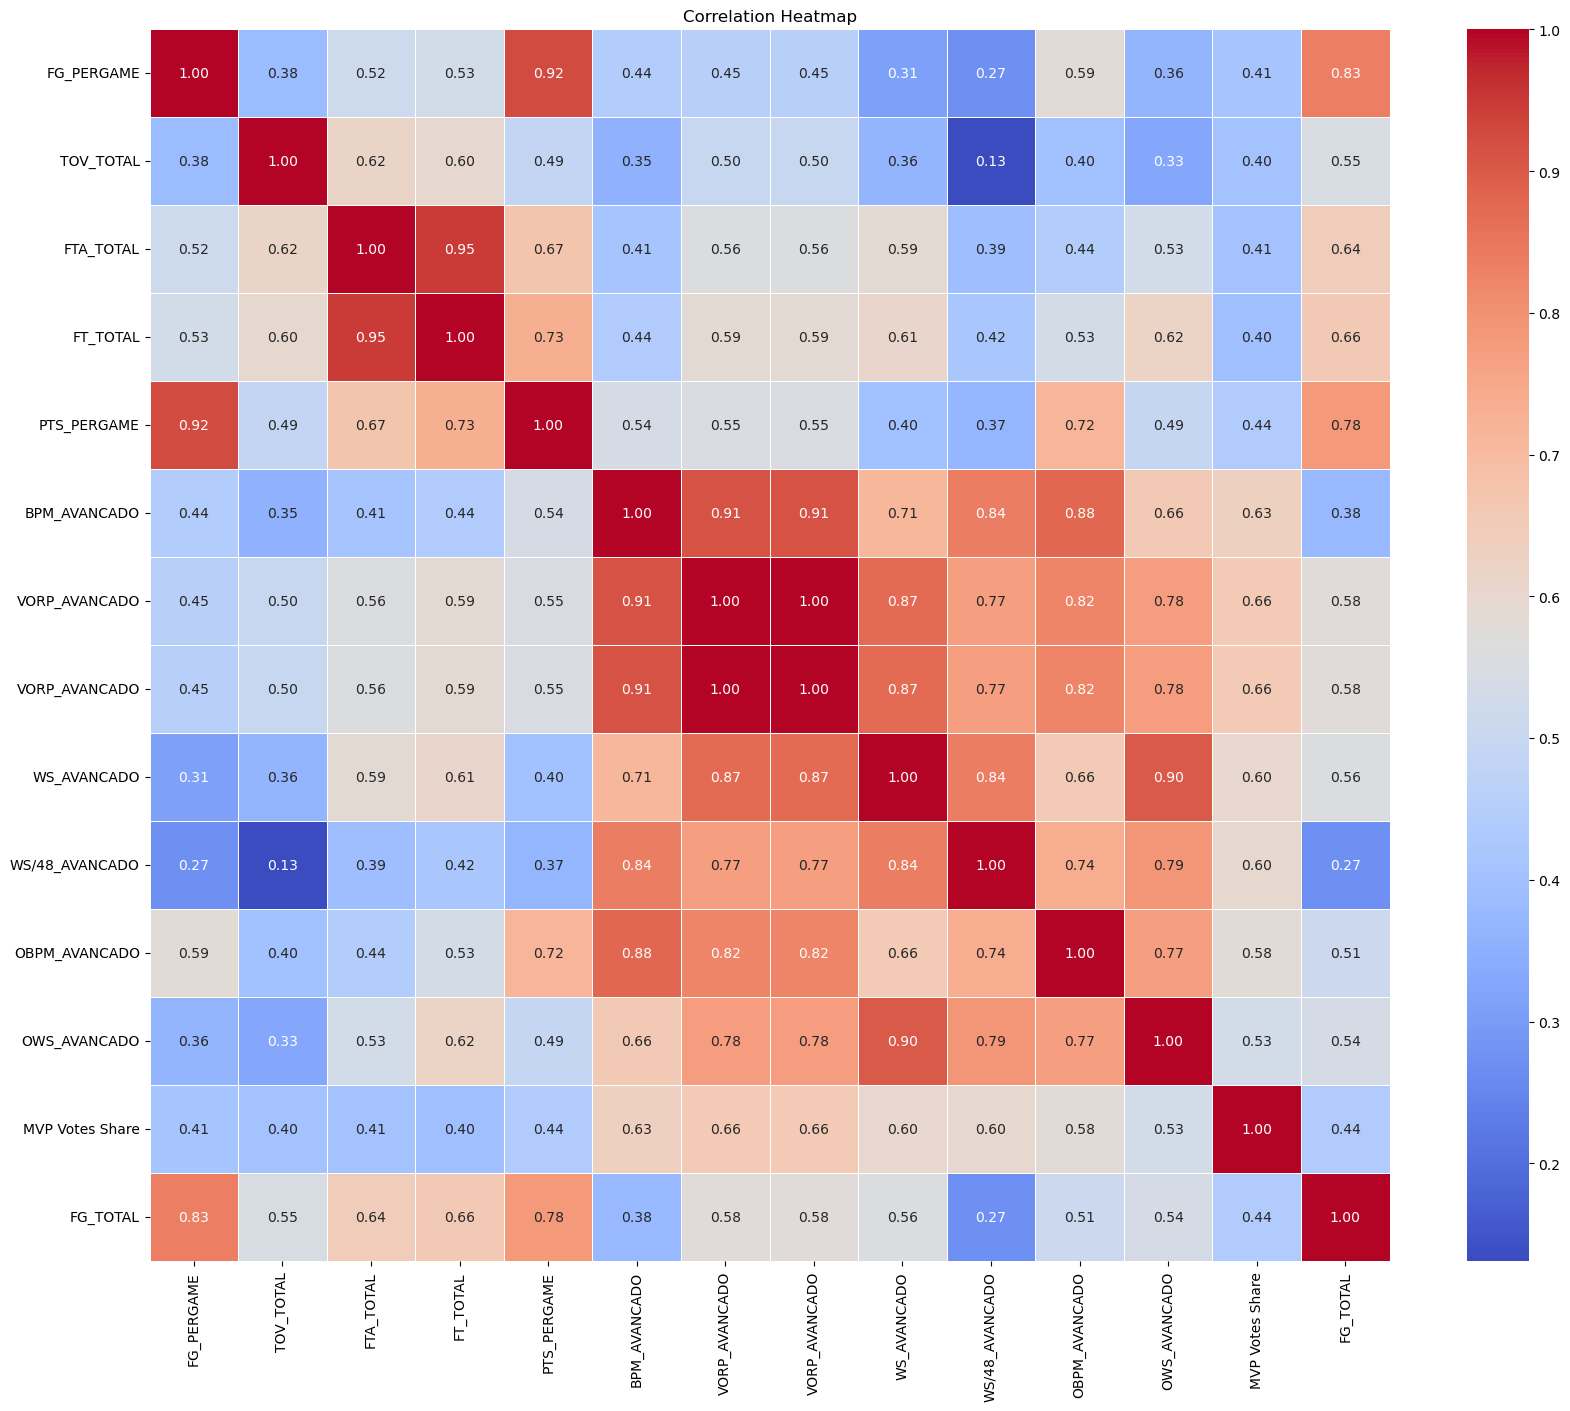

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'your_data' is your DataFrame with the specified columns
selected_columns = [ 'FG_PERGAME', 'TOV_TOTAL', 'FTA_TOTAL','FT_TOTAL','PTS_PERGAME','BPM_AVANCADO', 'VORP_AVANCADO',
                      'VORP_AVANCADO', 'WS_AVANCADO', 'WS/48_AVANCADO','OBPM_AVANCADO','OWS_AVANCADO','MVP Votes Share',
                    'FG_TOTAL']
                    
                   
# Subset the data with the selected columns
subset_data = data[selected_columns]

# Calculate the correlation matrix
correlation_matrix = subset_data.corr()

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [40]:
data['Season'].value_counts() # Number of players in the data per season based on based criteria

2011-12    29
2006-07    29
2007-08    29
2016-17    29
2020-21    28
2010-11    28
2009-10    27
2013-14    27
2003-04    26
2001-02    26
2018-19    25
2005-06    25
2021-22    25
2012-13    24
2015-16    24
2002-03    24
2004-05    23
2014-15    22
2008-09    21
2019-20    21
2017-18    20
Name: Season, dtype: int64

In [56]:
# Função para métricas
def func_metricas(y_test, y_pred, metricas, modelo, season):
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²
    
    dict_met = {'Modelo': [modelo],
                'Season': [season],
                'RMSE': [rmse],
                'R²': [r2]}
    
    metrica = pd.DataFrame(data=dict_met)
    metricas = pd.concat([metricas,metrica])
    
    return metricas

In [57]:
data.shape

(532, 75)

In [58]:
#Applying different machine learning algorithms to train and test the model

In [59]:
def func_models(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metricas = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:

        # Separating training and testing bases
        season_teste = season

        data_train = data[data['Season']!=season_teste]
        data_test = data[data['Season']==season_teste]

        X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_train = data_train['MVP Votes Share']

        X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_test = data_test['MVP Votes Share']

        initial_results = data_test[['Player','Season','MVP Votes Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)
        

        for modelo in models:
            # Creating instance for each model
            if modelo=='SVR':
                param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                             'kernel': ['linear','rbf','poly'],
                             'gamma': ['scale','auto'],
                             'degree': [2,3,4],
                             'epsilon': [0.1,0.5,1]}
                svr_model = SVR()
                grid = GridSearchCV(svr_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = SVR(**grid.best_params_)
                best_params.append(grid.best_params_)

            elif modelo=='Elastic Net':
                param_grid = {'alpha':[0.01,0.1,1,5,10,50,100],'l1_ratio':[0.01,0.1,0.5,0.7,0.95,0.99,1]}
                elastic_net_model = ElasticNet()
                grid = GridSearchCV(elastic_net_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                grid.best_params_
                model = ElasticNet(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif modelo=='Random Forest':
                param_grid = {'n_estimators': [15,25,50,64,100,150,200],
                             'max_features': [2,3,4,5],
                             'bootstrap': [True,False],
                             'oob_score': [True]}
                rfc = RandomForestRegressor()
                grid = GridSearchCV(rfc, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = RandomForestRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif modelo=='AdaBoost':
                param_grid = {'n_estimators': [5,10,20,30,40,50,100],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5]}
                ada_model = AdaBoostRegressor()
                grid = GridSearchCV(ada_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = AdaBoostRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif modelo=='Gradient Boosting':
                param_grid = {'n_estimators': [10,20,30,40,50],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                             'max_depth': [3,4,5]}
                gb_model = GradientBoostingRegressor()
                grid = GridSearchCV(gb_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = GradientBoostingRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif modelo=='LGBM':
                param_grid = {'learning_rate':[0.01,0.1,0.2,0.3],
                              'num_leaves':[5,10,20,30],
                              'min_data_in_leaf':[10,25,50],
                              'max_depth':[2,3,4],
                              'feature_fraction':[0.6,0.7,0.8,0.9],
                              'min_gain_to_split':[0,0.01,0.1,0.2],
                              'verbose':[-1]}
                lgbm_model = LGBMRegressor()
                grid = GridSearchCV(lgbm_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = LGBMRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            model.fit(scaled_X_train, y_train)
            print(path_data + modelo + '.dat')
            pickle.dump(model, open(path_data + modelo + '.dat', 'wb'))

            
            y_pred = model.predict(scaled_X_test)
            metricas = func_metricas(y_test, y_pred, metricas, modelo, season)

            apoio = initial_results.copy()
            apoio['Predicted MVP Share '+modelo] = pd.Series(y_pred).values

            results_sorted = apoio.sort_values(by='Predicted MVP Share '+modelo,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+modelo] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Votes Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
    
    #np.savetxt(path_data+sep+r'Models\params.csv', best_params, delimiter =', ', fmt ='% s')
    
    return final_results, metricas, best_params

In [60]:
def media_metricas(metricas):
    # Média de cada um dos models
    final_metricas = pd.DataFrame()
    for modelo in metricas['Modelo'].unique():
        metrica = metricas[metricas['Modelo']==modelo]
        rmse = round(metrica['RMSE'].mean(),3)
        r2 = round(metrica['R²'].mean(),3)

        dict_met = {'Modelo': [modelo],
                    'RMSE': [rmse],
                    'R²': [r2]}

        apoio = pd.DataFrame(data=dict_met)
        final_metricas = pd.concat([final_metricas,apoio], ignore_index=True)
    return final_metricas

In [61]:
final_results, metricas, best_params = func_models(data, seasons, models, 1)
final_metricas = media_metricas(metricas)
final_metricas

SVM.dat


,Modelo,RMSE,R²
0,SVM,0.091,0.853


In [47]:
def create_rank(final_results, n_rank):
    rank_final = pd.DataFrame()

    for season in final_results['Season'].unique():
        temp = final_results[final_results['Season']==season]
        rank = pd.DataFrame()
        rank_real = temp.sort_values(by='MVP Votes Share', ascending=False)[:n_rank].reset_index(drop=True)
        rank['MVP Rank Real'] = rank_real['Player']
        rank['MVP Share Real'] = rank_real['MVP Votes Share']
        for modelo in models:
            try:
                temp2 = temp.sort_values(by='Predicted MVP Share '+modelo, ascending=False)[:n_rank].reset_index(drop=True)
                rank['MVP Rank '+modelo] = temp2['Player']
                rank['MVP Share '+modelo] = round(temp2['Predicted MVP Share '+modelo],3)
            except:
                continue

        rank['Season'] = season    
        rank_final = pd.concat([rank_final, rank], ignore_index=True)
    
    return rank_final

In [48]:
rank_final = create_rank(final_results, 5)
rank_final

,MVP Rank Real,MVP Share Real,MVP Rank SVM,MVP Share SVM,MVP Rank Elastic Net,MVP Share Elastic Net,MVP Rank Random Forest,MVP Share Random Forest,MVP Rank AdaBoost,MVP Share AdaBoost,MVP Rank Gradient Boosting,MVP Share Gradient Boosting,MVP Rank LGBM,MVP Share LGBM,Season
0,Nikola Jokić,0.875,Nikola Jokić,0.800,Nikola Jokić,0.552,Nikola Jokić,0.745,Nikola Jokić,0.638,Nikola Jokić,0.599,Giannis Antetokounmpo,0.709,2021-22
1,Joel Embiid,0.706,Giannis Antetokounmpo,0.687,Giannis Antetokounmpo,0.388,Giannis Antetokounmpo,0.602,Giannis Antetokounmpo,0.617,Giannis Antetokounmpo,0.493,Nikola Jokić,0.693,2021-22
2,Giannis Antetokounmpo,0.595,Joel Embiid,0.535,Joel Embiid,0.288,Joel Embiid,0.422,Joel Embiid,0.238,Joel Embiid,0.342,Joel Embiid,0.466,2021-22
3,Devin Booker,0.216,Luka Dončić,0.292,Luka Dončić,0.286,LeBron James,0.222,Luka Dončić,0.203,Luka Dončić,0.239,Luka Dončić,0.186,2021-22
4,Luka Dončić,0.146,Ja Morant,0.174,Ja Morant,0.194,Luka Dončić,0.216,LeBron James,0.194,LeBron James,0.217,LeBron James,0.184,2021-22


In [51]:
import pickle

def open_model(modelo):
    with open(modelo + '.dat','rb') as file:
        model = pickle.load(file, encoding='latin1')
    return model


In [52]:
def temporadas_antigas(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metricas = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:
            
        # Separando as bases de treino e teste
        season_teste = season

        data_train = data[data['Season']!=season_teste]
        data_test = data[data['Season']==season_teste]

        X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_train = data_train['MVP Votes Share']

        X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_test = data_test['MVP Votes Share']

        initial_results = data_test[['Player','Season','MVP Votes Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for modelo in models:
            
            if modelo=='Elastic Net':
                continue
            
            # Abrindo os models já criados          
            model = open_model(modelo)
                
            model.fit(scaled_X_train, y_train)
            y_pred = model.predict(scaled_X_test)
            metricas = func_metricas(y_test, y_pred, metricas, modelo, season)

            apoio = initial_results.copy()
            apoio['Predicted MVP Share '+modelo] = pd.Series(y_pred).values

            results_sorted = apoio.sort_values(by='Predicted MVP Share '+modelo,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+modelo] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Votes Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
        
    return final_results, metricas

In [53]:
final_results, metricas = temporadas_antigas(data, seasons, models, 16)
final_metricas = media_metricas(metricas)
final_metricas

,Modelo,RMSE,R²
0,SVM,0.134,0.650
1,Random Forest,0.129,0.674
2,AdaBoost,0.127,0.688
3,Gradient Boosting,0.133,0.655
4,LGBM,0.119,0.725


In [ ]:
rank_final = create_rank(final_results, 1)
rank_final


In [55]:
data.shape

(532, 75)

In [57]:
def fun(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metricas = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:

        # Separating training and testing bases
        season_teste = season

        data_train = data[data['Season']!=season_teste]
        data_test = data[data['Season']==season_teste]
        print(data_train)

        X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_train = data_train['MVP Votes Share']

        X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_test = data_test['MVP Votes Share']

        initial_results = data_test[['Player','Season','MVP Votes Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)
        

        

In [59]:
a = fun(data, seasons, models, 1)
print(a)


                    Player  Age   G  GS  MP_PERGAME  FG_PERGAME  FGA_PERGAME  \
25             Bam Adebayo   23  64  64        33.5         7.1         12.5   
26   Giannis Antetokounmpo   26  61  61        33.0        10.3         18.0   
27            Devin Booker   24  67  67        33.9         9.3         19.2   
28            Jaylen Brown   24  58  58        34.5         9.3         19.2   
29            Jimmy Butler   31  52  52        33.6         7.0         14.2   
..                     ...  ...  ..  ..         ...         ...          ...   
527        Peja Stojaković   24  71  71        37.3         7.7         15.9   
528            Ben Wallace   27  80  80        36.5         3.2          6.0   
529        Rasheed Wallace   27  79  79        37.5         7.6         16.3   
530           Chris Webber   28  54  54        38.4         9.9         19.9   
531            Bonzi Wells   25  74  69        31.7         6.6         14.0   

     FG%_PERGAME  3P_PERGAME  3PA_PERGA

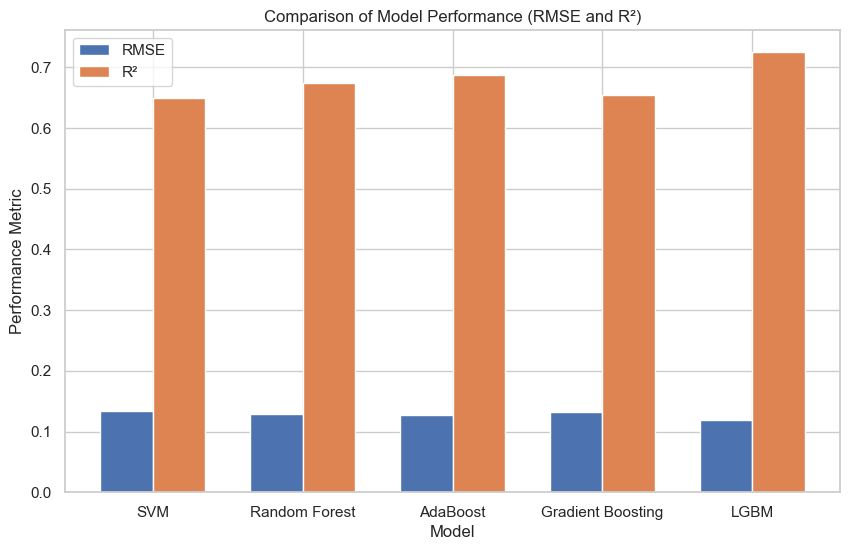

In [70]:
import matplotlib.pyplot as plt
import numpy as np



result_df = pd.DataFrame(final_metricas)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar width
bar_width = 0.35

# Set positions for bars on X-axis
bar_positions_rmse = np.arange(len(result_df['Modelo']))
bar_positions_r2 = bar_positions_rmse + bar_width

# Plot RMSE values
ax.bar(bar_positions_rmse, result_df['RMSE'], width=bar_width, label='RMSE')

# Plot R² values
ax.bar(bar_positions_r2, result_df['R²'], width=bar_width, label='R²')

# Customize the plot
ax.set_xticks(bar_positions_rmse + bar_width / 2)
ax.set_xticklabels(result_df['Modelo'])
ax.set_xlabel('Model')
ax.set_ylabel('Performance Metric')
ax.set_title('Comparison of Model Performance (RMSE and R²)')
ax.legend()

# Show the plot
plt.show()
